In [1]:
import pandas as pd
import matplotlib as plt
from matplotlib import cm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

file = pd.read_csv('insurance.csv')

print(file.info())
print(file.shape)

file.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
file.duplicated().any()
file =file.drop_duplicates()

In [3]:
file.sample(5)

,age,sex,bmi,children,smoker,region,charges
1122,53,female,36.860,3,yes,northwest,46661.44240
1189,23,female,28.000,0,no,southwest,13126.67745
695,26,female,40.185,0,no,northwest,3201.24515
668,62,male,32.015,0,yes,northeast,45710.20785
1278,39,male,29.925,1,yes,northeast,22462.04375


In [4]:
file =file.drop_duplicates().reset_index()
file.shape

(1337, 8)

<AxesSubplot:>

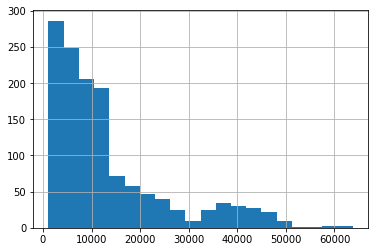

In [5]:
file['charges'].hist(bins=20)

<AxesSubplot:>

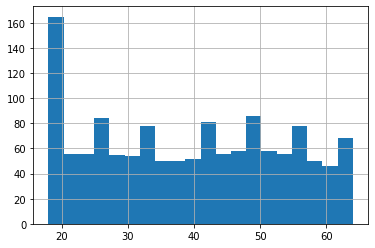

In [6]:
file['age'].hist(bins=20)

<AxesSubplot:>

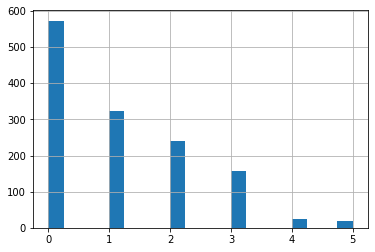

In [7]:
file['children'].hist(bins=20)

In [8]:
file[['sex', 'charges']].groupby(by='sex').mean()

,charges
sex,
female,12569.578844
male,13974.998864


In [9]:
file[['smoker', 'charges']].groupby(by='smoker').mean()

,charges
smoker,
no,8440.660307
yes,32050.231832


In [10]:
file[['smoker', 'charges']].groupby(by='smoker').describe()

charges                                                        \
         count          mean           std         min           25%   
smoker                                                                 
no      1063.0   8440.660307   5992.973800   1121.8739   3988.883500   
yes      274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                                                
                50%           75%          max  
smoker                                          
no       7345.72660  11363.019100  36910.60803  
yes     34456.34845  41019.207275  63770.42801

In [11]:
file[['children', 'charges']].groupby(by='children').mean('charges').sort_values(by='charges', ascending=False)

,charges
children,
3,15355.318367
2,15073.563734
4,13850.656311
1,12731.171832
0,12384.695344
5,8786.035247


In [12]:
file['user_ID'] = pd.DataFrame(file.index).astype(int)
file = file[['user_ID', 'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']]
file

# file_feat_transp_count = pd.DataFrame(file_feat_transp[file_feat_transp[col]].sum())

,user_ID,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1332,1332,50,male,30.970,3,no,northwest,10600.54830
1333,1333,18,female,31.920,0,no,northeast,2205.98080
1334,1334,18,female,36.850,0,no,southeast,1629.83350
1335,1335,21,female,25.800,0,no,southwest,2007.94500


In [13]:
df_user = (
    file[['user_ID', 'charges']]
    .groupby('user_ID')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_user['cumsum'] = df_user['total_charges'].cumsum()
value_80proc = int(df_user['total_charges'].sum()*0.8)
df_user['top_user'] = df_user['cumsum'] > value_80proc

top_user = set(df_user[df_user['top_user']]['user_ID'])
len(top_user)/file['user_ID'].nunique()

0.5205684367988033

In [14]:
df_user

,user_ID,total_charges,cumsum,top_user
543,543,63770.42801,6.377043e+04,False
1299,1299,62592.87309,1.263633e+05,False
1229,1229,60021.39897,1.863847e+05,False
577,577,58571.07448,2.449558e+05,False
818,818,55135.40209,3.000912e+05,False
...,...,...,...,...
22,22,1137.01100,1.774966e+07,True
662,662,1136.39940,1.775080e+07,True
1243,1243,1135.94070,1.775193e+07,True
807,807,1131.50660,1.775306e+07,True


In [15]:
df_user_worst = (
    file[['user_ID', 'charges']]
    .groupby('user_ID')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_user_worst['cumsum'] = df_user_worst['total_charges'].cumsum()
value_80proc = int(df_user_worst['total_charges'].sum()*0.8)
df_user_worst['undesirable_user'] = df_user_worst['cumsum'] < value_80proc


In [16]:
df_user_worst=df_user_worst[['user_ID', 'undesirable_user']]
df_user_worst = df_user_worst.merge(file, on='user_ID')
df_user_worst = df_user_worst[df_user_worst['undesirable_user'] ==True]
df_user_worst

,user_ID,undesirable_user,age,sex,bmi,children,smoker,region,charges
0,543,True,54,female,47.410,0,yes,southeast,63770.42801
1,1299,True,45,male,30.360,0,yes,southeast,62592.87309
2,1229,True,52,male,34.485,3,yes,northwest,60021.39897
3,577,True,31,female,38.095,1,yes,northeast,58571.07448
4,818,True,33,female,35.530,0,yes,northwest,55135.40209
...,...,...,...,...,...,...,...,...,...
636,682,True,53,male,24.320,0,no,northwest,9863.47180
637,527,True,51,female,25.800,1,no,southwest,9861.02500
638,279,True,51,female,21.560,1,no,southeast,9855.13140
639,1027,True,54,male,31.600,0,no,southwest,9850.43200


In [17]:
df_user = df_user[['user_ID', 'top_user']]
file = file.merge(df_user, on='user_ID')
file =file[file['top_user'] ==True]
file

,user_ID,age,sex,bmi,children,smoker,region,charges,top_user
1,1,18,male,33.77,1,no,southeast,1725.5523,True
2,2,28,male,33.00,3,no,southeast,4449.4620,True
4,4,32,male,28.88,0,no,northwest,3866.8552,True
5,5,31,female,25.74,0,no,southeast,3756.6216,True
6,6,46,female,33.44,1,no,southeast,8240.5896,True
...,...,...,...,...,...,...,...,...,...
1325,1325,42,female,32.87,0,no,northeast,7050.0213,True
1326,1326,51,male,30.03,1,no,southeast,9377.9047,True
1333,1333,18,female,31.92,0,no,northeast,2205.9808,True
1334,1334,18,female,36.85,0,no,southeast,1629.8335,True


In [18]:
df_children = (
    file[['children', 'charges']]
    .groupby('children')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_children['cumsum'] = df_children['total_charges'].cumsum()
value_80proc = int(df_children['total_charges'].sum()*0.8)
df_children['top_children'] = df_children['cumsum'] < value_80proc

top_children = set(df_children[df_children['top_children']]['children'])
df_children = df_children[['children', 'top_children']]

In [19]:
len(top_children)/file['children'].nunique()

0.3333333333333333

In [20]:
df_children

,children,top_children
1,1,True
0,0,True
2,2,False
3,3,False
5,5,False
4,4,False


In [21]:
df_smoker = (
    file[['smoker', 'charges']]
    .groupby('smoker')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_smoker['cumsum'] = df_smoker['total_charges'].cumsum()
value_80proc = int(df_smoker['total_charges'].sum()*0.8)
df_smoker['top_smoker'] = df_smoker['cumsum'] < value_80proc

top_smoker= set(df_smoker[df_smoker['top_smoker']]['smoker'])
df_smoker = df_smoker[['smoker', 'top_smoker']]

In [22]:
len(top_smoker)/file['smoker'].nunique()

0.0

In [23]:
df_age = (
    file[['age', 'charges']]
    .groupby('age')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_age['cumsum'] = df_age['total_charges'].cumsum()
value_80proc = int(df_age['total_charges'].sum()*0.8)
df_age['top_age'] = df_age['cumsum'] < value_80proc

top_age= set(df_age[df_age['top_age']]['age'])
df_age[['age', 'top_age']].groupby(by='top_age').describe()
df_age = df_age[['age', 'top_age']]

In [24]:
len(top_age)/file['age'].nunique()

0.6388888888888888

In [25]:
df_sex = (
    file[['sex', 'charges']]
    .groupby('sex')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_sex['cumsum'] = df_sex['total_charges'].cumsum()
value_80proc = int(df_sex['total_charges'].sum()*0.8)
df_sex['top_sex'] = df_sex['cumsum'] < value_80proc

top_sex= set(df_sex[df_sex['top_sex']]['sex'])
df_sex = df_sex[['sex', 'top_sex']]

In [26]:
len(top_sex)/file['sex'].nunique()

0.5

In [27]:
df_bmi = (
    file[['bmi', 'charges']]
    .groupby('bmi')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_bmi['cumsum'] = df_bmi['total_charges'].cumsum()
value_80proc = int(df_bmi['total_charges'].sum()*0.8)
df_bmi['top_bmi'] = df_bmi['cumsum'] < value_80proc

top_bmi= set(df_bmi[df_bmi['top_bmi']]['bmi'])
df_bmi[['bmi', 'top_bmi']].groupby(by='top_bmi').describe()
df_bmi = df_bmi[['bmi', 'top_bmi']]

In [28]:
len(top_bmi)/file['bmi'].nunique()

0.5513784461152882

In [29]:
df_region = (
    file[['region', 'charges']]
    .groupby('region')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_region['cumsum'] = df_region['total_charges'].cumsum()
value_80proc = int(df_region['total_charges'].sum()*0.8)
df_region['top_region'] = df_region['cumsum'] < value_80proc

top_region= set(df_region[df_region['top_region']]['region'])
df_region = df_region[['region', 'top_region']]

In [30]:
len(top_region)/file['region'].nunique()

0.75

In [31]:
file = file.merge(df_region, on='region')
file = file.merge(df_children, on='children')
file = file.merge(df_smoker, on='smoker')
file = file.merge(df_age, on='age')
file = file.merge(df_sex, on='sex')
file = file.merge(df_bmi, on='bmi')
file


,user_ID,age,sex,bmi,children,smoker,region,charges,top_user,top_region,top_children,top_smoker,top_age,top_sex,top_bmi
0,1,18,male,33.770,1,no,southeast,1725.55230,True,True,True,False,True,False,False
1,1096,22,male,33.770,0,no,southeast,1674.63230,True,True,True,False,False,False,False
2,270,18,male,29.370,1,no,southeast,1719.43630,True,True,True,False,True,False,True
3,609,47,female,29.370,1,no,southeast,8547.69130,True,True,True,False,True,True,True
4,709,18,male,35.200,1,no,southeast,1727.54000,True,True,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,81,45,female,38.285,0,no,northeast,7935.29115,True,False,True,False,True,True,True
692,445,45,female,33.100,0,no,southwest,7345.08400,True,True,True,False,True,True,True
693,652,45,female,36.300,2,no,southeast,8527.53200,True,True,False,False,True,True,True
694,1233,45,female,27.830,2,no,southeast,8515.75870,True,True,False,False,True,True,True


In [32]:
file_feat = file[['top_region', 'top_children', 'top_smoker', 'top_age', 'top_sex', 'top_bmi']]
file_feat

,top_region,top_children,top_smoker,top_age,top_sex,top_bmi
0,True,True,False,True,False,False
1,True,True,False,False,False,False
2,True,True,False,True,False,True
3,True,True,False,True,True,True
4,True,True,False,True,False,True
...,...,...,...,...,...,...
691,False,True,False,True,True,True
692,True,True,False,True,True,True
693,True,False,False,True,True,True
694,True,False,False,True,True,True


In [33]:
file_feat_transp =file_feat.transpose()
file_feat_transp.sum()



file_feat_transp_count =pd.DataFrame(file_feat_transp.sum())
file_feat_transp_count

file_feat_transp_count['user_ID'] = file['user_ID']
file_feat_transp_count
  

,0,user_ID
0,3,1
1,2,1096
2,4,270
3,5,609
4,4,709
...,...,...
691,4,81
692,5,445
693,4,652
694,4,1233


In [34]:
# file_feat['sum_top'] = file_feat_transp_count
# file_feat= file_feat[['user_ID', 'sum_top']]
# print(file_feat.shape)

In [35]:
file = file.merge(file_feat_transp_count, on='user_ID', how='left')
file.head()
file.rename(columns={0 :'sum_top'}, inplace=True)
file

,user_ID,age,sex,bmi,children,smoker,region,charges,top_user,top_region,top_children,top_smoker,top_age,top_sex,top_bmi,sum_top
0,1,18,male,33.770,1,no,southeast,1725.55230,True,True,True,False,True,False,False,3
1,1096,22,male,33.770,0,no,southeast,1674.63230,True,True,True,False,False,False,False,2
2,270,18,male,29.370,1,no,southeast,1719.43630,True,True,True,False,True,False,True,4
3,609,47,female,29.370,1,no,southeast,8547.69130,True,True,True,False,True,True,True,5
4,709,18,male,35.200,1,no,southeast,1727.54000,True,True,True,False,True,False,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,81,45,female,38.285,0,no,northeast,7935.29115,True,False,True,False,True,True,True,4
692,445,45,female,33.100,0,no,southwest,7345.08400,True,True,True,False,True,True,True,5
693,652,45,female,36.300,2,no,southeast,8527.53200,True,True,False,False,True,True,True,4
694,1233,45,female,27.830,2,no,southeast,8515.75870,True,True,False,False,True,True,True,4


In [36]:
file['sum_top'] = file['sum_top'].replace(6,1)
file['sum_top'] = file['sum_top'].replace(5,2)
file['sum_top'] = file['sum_top'].replace(4,3)
file['sum_top'] = file['sum_top'].replace(3,4)
file['sum_top'] = file['sum_top'].replace(2,5)
file['sum_top'] = file['sum_top'].replace(1,6)
file['sum_top'] = file['sum_top'].replace(0,7)
file

,user_ID,age,sex,bmi,children,smoker,region,charges,top_user,top_region,top_children,top_smoker,top_age,top_sex,top_bmi,sum_top
0,1,18,male,33.770,1,no,southeast,1725.55230,True,True,True,False,True,False,False,4
1,1096,22,male,33.770,0,no,southeast,1674.63230,True,True,True,False,False,False,False,5
2,270,18,male,29.370,1,no,southeast,1719.43630,True,True,True,False,True,False,True,4
3,609,47,female,29.370,1,no,southeast,8547.69130,True,True,True,False,True,True,True,5
4,709,18,male,35.200,1,no,southeast,1727.54000,True,True,True,False,True,False,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,81,45,female,38.285,0,no,northeast,7935.29115,True,False,True,False,True,True,True,4
692,445,45,female,33.100,0,no,southwest,7345.08400,True,True,True,False,True,True,True,5
693,652,45,female,36.300,2,no,southeast,8527.53200,True,True,False,False,True,True,True,4
694,1233,45,female,27.830,2,no,southeast,8515.75870,True,True,False,False,True,True,True,4


In [37]:
file.rename(columns={'sum_top' :'category'}, inplace=True)
file = file[['user_ID','age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'category']]
file['category'].value_counts()

4    452
5    220
6     22
7      2
Name: category, dtype: int64

In [38]:
file['category'] = file['category'].replace(4,1)
file['category'] = file['category'].replace(5,2)
file['category'] = file['category'].replace(6,3)
file['category'] = file['category'].replace(7,4)
file.sample(5)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24800\4162488396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['category'] = file['category'].replace(4,1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24800\4162488396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['category'] = file['category'].replace(5,2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24800\4162488396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,user_ID,age,sex,bmi,children,smoker,region,charges,category
576,498,44,female,23.980,2,no,southeast,8211.10020,1
389,734,49,female,34.770,1,no,northwest,9583.89330,2
92,567,41,male,30.590,2,no,northwest,7256.72310,1
225,762,27,male,26.030,0,no,northeast,3070.80870,2
151,392,48,male,31.445,1,no,northeast,8964.06055,1


In [39]:
df_user_worst['category'] = 5
df_user_worst = df_user_worst[['user_ID', 'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'category']]
df_user_worst


,user_ID,age,sex,bmi,children,smoker,region,charges,category
0,543,54,female,47.410,0,yes,southeast,63770.42801,5
1,1299,45,male,30.360,0,yes,southeast,62592.87309,5
2,1229,52,male,34.485,3,yes,northwest,60021.39897,5
3,577,31,female,38.095,1,yes,northeast,58571.07448,5
4,818,33,female,35.530,0,yes,northwest,55135.40209,5
...,...,...,...,...,...,...,...,...,...
636,682,53,male,24.320,0,no,northwest,9863.47180,5
637,527,51,female,25.800,1,no,southwest,9861.02500,5
638,279,51,female,21.560,1,no,southeast,9855.13140,5
639,1027,54,male,31.600,0,no,southwest,9850.43200,5


In [40]:
file = pd.concat([file, df_user_worst])
file

,user_ID,age,sex,bmi,children,smoker,region,charges,category
0,1,18,male,33.77,1,no,southeast,1725.5523,1
1,1096,22,male,33.77,0,no,southeast,1674.6323,2
2,270,18,male,29.37,1,no,southeast,1719.4363,1
3,609,47,female,29.37,1,no,southeast,8547.6913,2
4,709,18,male,35.20,1,no,southeast,1727.5400,1
...,...,...,...,...,...,...,...,...,...
636,682,53,male,24.32,0,no,northwest,9863.4718,5
637,527,51,female,25.80,1,no,southwest,9861.0250,5
638,279,51,female,21.56,1,no,southeast,9855.1314,5
639,1027,54,male,31.60,0,no,southwest,9850.4320,5


In [41]:
# pd.get_dummies(file[['sex', 'smoker', 'region']])
file_dummies = pd.get_dummies(file[['sex', 'smoker', 'region']])
file_dummies['user_ID'] = file['user_ID']
file_dummies

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,user_ID
0,0,1,1,0,0,0,1,0,1
1,0,1,1,0,0,0,1,0,1096
2,0,1,1,0,0,0,1,0,270
3,1,0,1,0,0,0,1,0,609
4,0,1,1,0,0,0,1,0,709
...,...,...,...,...,...,...,...,...,...
636,0,1,1,0,0,1,0,0,682
637,1,0,1,0,0,0,0,1,527
638,1,0,1,0,0,0,1,0,279
639,0,1,1,0,0,0,0,1,1027


In [42]:
file = file.merge(file_dummies, on='user_ID')
file = file[['user_ID', 'age', 'sex_female', 'sex_male', 'bmi', 'children', 'smoker_no', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'charges', 'category']]
file = file.sort_values(by='user_ID')
file = file[['age', 'sex_female', 'sex_male', 'bmi', 'children', 'smoker_no', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'charges', 'category']]
file

,age,sex_female,sex_male,bmi,children,smoker_no,region_northeast,region_northwest,region_southeast,region_southwest,charges,category
1027,19,1,0,27.900,0,0,0,0,0,1,16884.92400,5
0,18,0,1,33.770,1,1,0,0,1,0,1725.55230,1
123,28,0,1,33.000,3,1,0,0,1,0,4449.46200,1
935,33,0,1,22.705,0,1,0,1,0,0,21984.47061,5
245,32,0,1,28.880,0,1,0,1,0,0,3866.85520,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1286,50,0,1,30.970,3,1,0,1,0,0,10600.54830,5
526,18,1,0,31.920,0,1,1,0,0,0,2205.98080,1
473,18,1,0,36.850,0,1,0,0,1,0,1629.83350,2
507,21,1,0,25.800,0,1,0,0,0,1,2007.94500,1


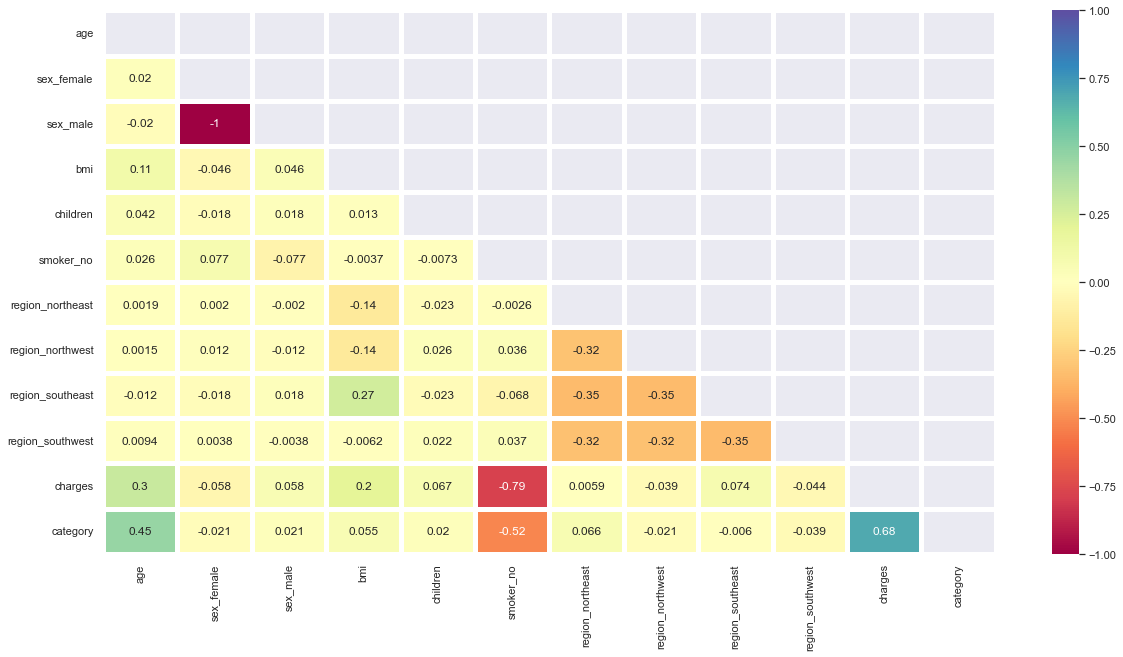

In [43]:
icorrelation_matrix = file.corr()
sns.set(rc={'figure.figsize':(20,10)}) 
mask = np.triu(np.ones_like(correlation_matrix), k=0) 
sns.heatmap(correlation_matrix, annot=True, cmap = 'Spectral', linewidths=5, mask=mask, vmax=1)
pass

In [44]:
def plot_boxes(x_df,y_df):
    boxes = len(y_df.unique())
    sns.set(rc={'figure.figsize':(20, boxes/1.5)}) 
    sns.boxplot(y=y_df, x=x_df, orient="h", fliersize=10);

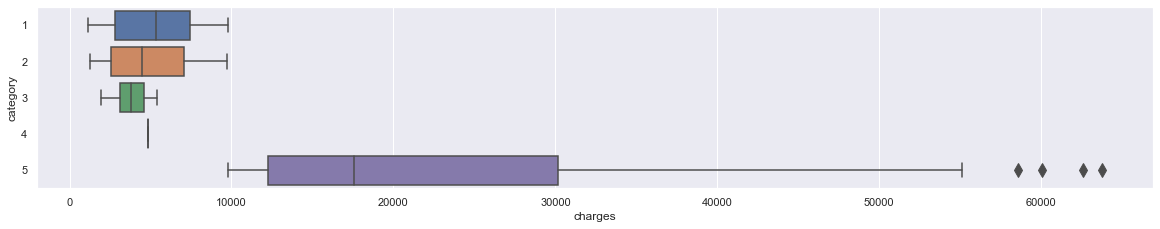

In [45]:
plot_boxes(file["charges"], file["category"])

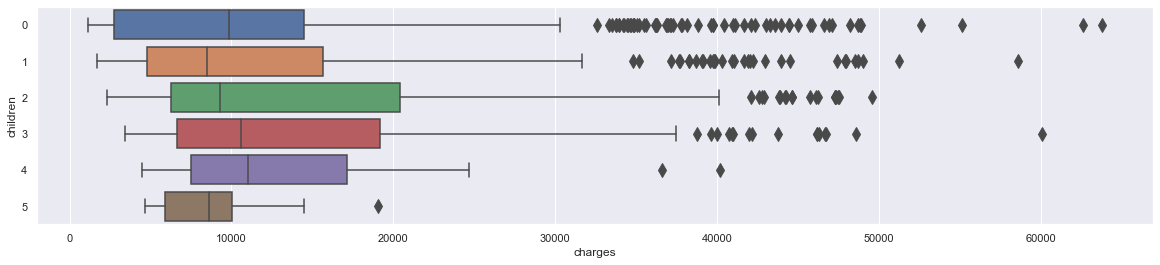

In [46]:
plot_boxes(file["charges"], file["children"])

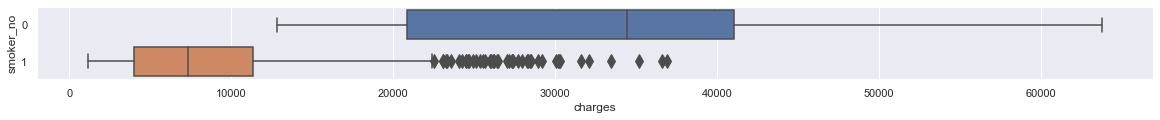

In [47]:
plot_boxes(file["charges"], file["smoker_no"])

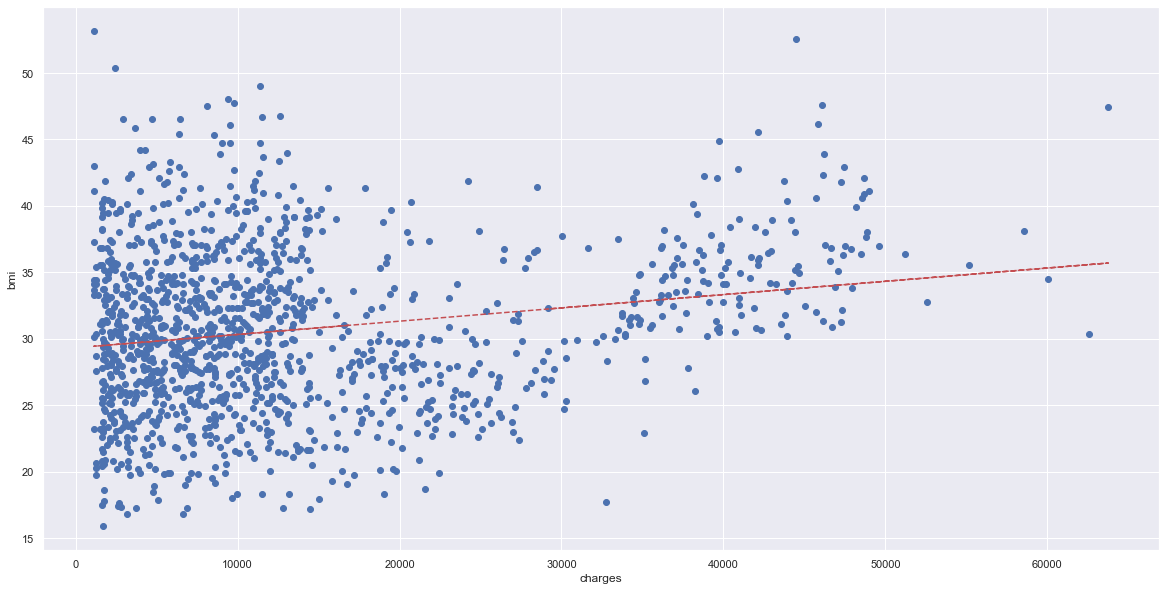

In [48]:
sns.set(rc={'figure.figsize':(20,10)}) 
y = file["bmi"]
x = file["charges"]
plt.scatter(x, y)
plt.ylabel("bmi")
plt.xlabel("charges")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--");

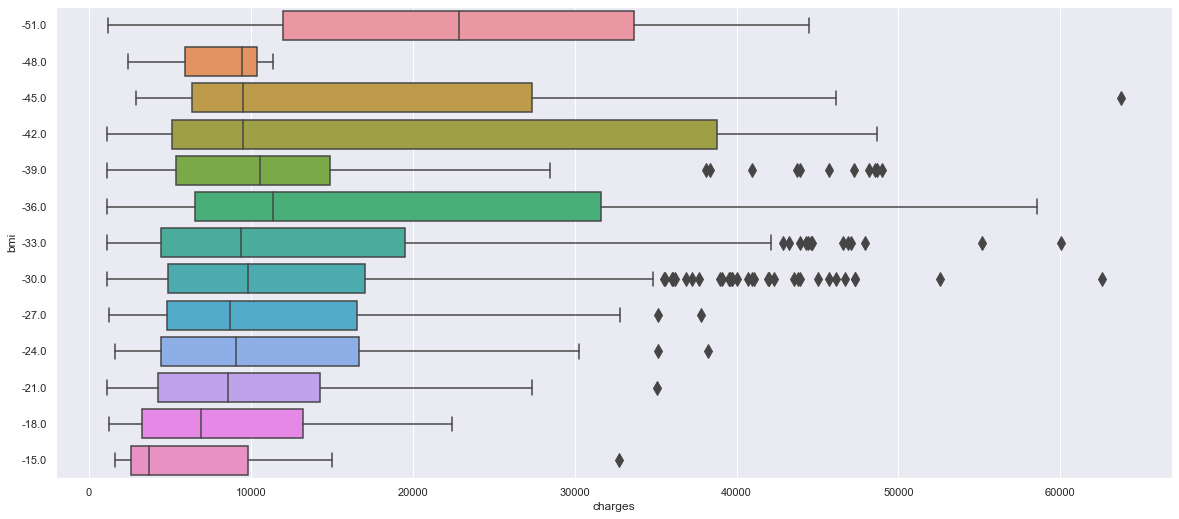

In [49]:
plot_boxes(file["charges"], -(file["bmi"]//3)*3)

In [50]:
file.head()

,age,sex_female,sex_male,bmi,children,smoker_no,region_northeast,region_northwest,region_southeast,region_southwest,charges,category
1027,19,1,0,27.900,0,0,0,0,0,1,16884.92400,5
0,18,0,1,33.770,1,1,0,0,1,0,1725.55230,1
123,28,0,1,33.000,3,1,0,0,1,0,4449.46200,1
935,33,0,1,22.705,0,1,0,1,0,0,21984.47061,5
245,32,0,1,28.880,0,1,0,1,0,0,3866.85520,1


In [51]:
x = file.drop(["charges","category", "sex_female", "region_southwest"], axis=1)
y = file["charges"]

In [53]:
def model_summary(y_test,y_pred,title="Title"): 
    sns.set(rc={'figure.figsize':(10,10)}) 
    max1 = y_pred.max()
    max2 = y_test.max()
    m = min(max1,max2)
    plt.scatter(y_test,y_pred)
    plt.xlabel("test values")
    plt.ylabel("prediceted values")
    plt.plot([0,m],[0,m],'r--')
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    plt.title(str(title).upper(), font={'size':16})
    t1, t2, t3, t4 = "Mean:", "RMSE:", "MAE:", "R^2:"
    s1, s2, s3, s4 = format(y_pred.mean(),'.3f'), format(rmse,'.3f'), format(mae,'.3f'), format(r2,'.3f')
    plt.annotate(f"{t1} {s1:>10} \n{t2} {s2:>10} \n{t3} {s3:>11} \n{t4} {s4:>11}", [0,max1*.9], 
                    font={'size':13, 'family':'courier new', 'weight':'bold'}, 
                    bbox={'facecolor': 'white', 'edgecolor' : 'black', 'alpha': 0.5, 'pad': 10})

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3, random_state=24)
rf = RandomForestRegressor().fit(x_train, y_train)

In [55]:
rf.score(x_test, y_test)

0.8563530754784503

In [56]:
y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

MSE: 22953521.74052154, MAE: 2763.3569836530637, R^2: 0.8563530754784503


In [57]:
param_grid = {"max_depth": list(range(2,11,1)),
              "max_features": list(range(6,11,2)),
              "ccp_alpha" : [0, 0.05, 0.1, 0.15],
              "n_estimators" : [100, 200, 500, 1000]
              }
cv_search = RandomizedSearchCV(rf, param_grid, random_state=42)
cv_search.fit(x_train, y_train)
cv_search.best_estimator_;

In [58]:
rf_better = grid_search.best_estimator_
rf_better.fit(x_train, y_train)
rf_better.score(x_test,y_test)

0.8752451741561893

In [59]:
rf_y_pred = rf_better.predict(x_test)

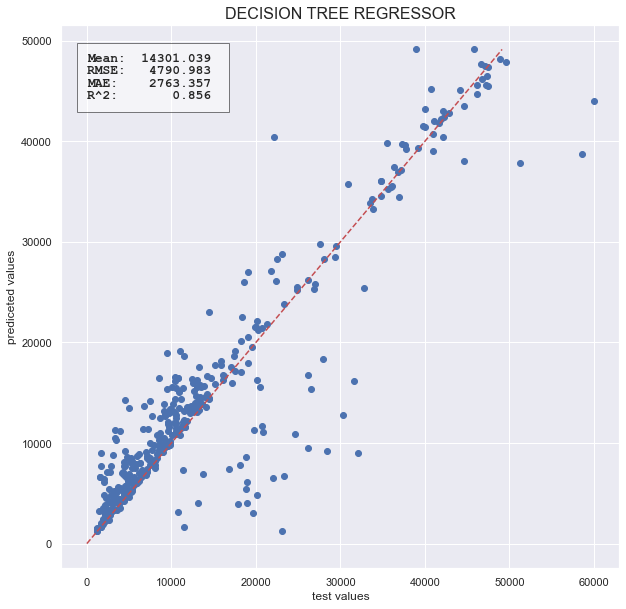

In [272]:
model_summary(y_test,y_pred, "Decision Tree Regressor")

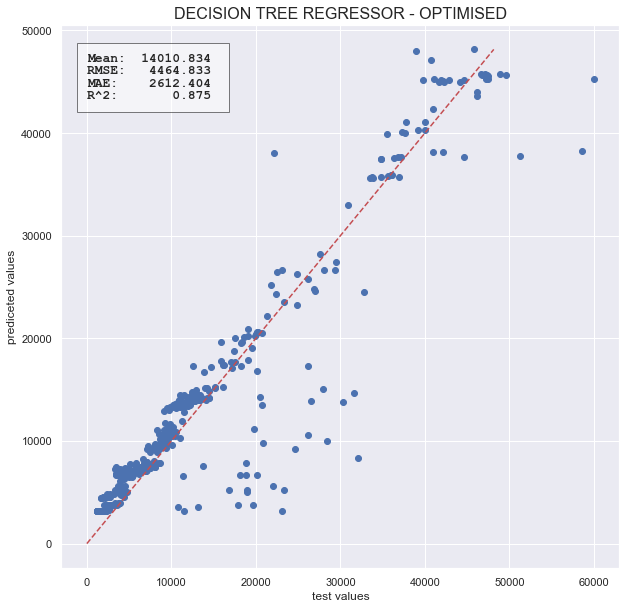

In [273]:
model_summary(y_test,rf_y_pred, "Decision Tree Regressor - optimised")

In [108]:
rf_importance = rf_better.feature_importances_
for i,v in enumerate(rf_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.12181
Feature: 1, Score: 0.00036
Feature: 2, Score: 0.16839
Feature: 3, Score: 0.01141
Feature: 4, Score: 0.69666
Feature: 5, Score: 0.00099
Feature: 6, Score: 0.00015
Feature: 7, Score: 0.00023


In [189]:
def feature_importance_barplot(x, feature_importance, type_of_ML):
    labels = list(x.columns)
    loc = range(0,len(labels),1)
    importance_prc = feature_importance*100
    ax = plt.bar([x for x in loc], importance_prc, color=cm.Blues_r(1-((66+importance_prc)/100)))
    plt.xticks(ticks=list(loc),labels=labels,rotation="45")
    plt.bar_label(ax, labels=importance_prc.round(2), padding=5)
    plt.ylabel("importance [%]")
    plt.yticks(rotation="90")
    plt.title((str(type_of_ML)+" - feature importance").upper())
    plt.show();

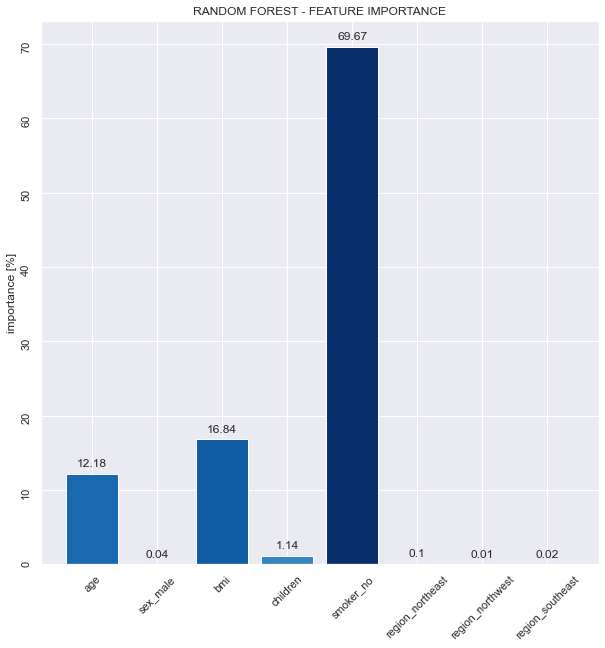

In [190]:
feature_importance_barplot(x, rf_importance, "random forest")

In [194]:
def outlier_iqr(df, columns):
    lower_limit = {}
    upper_limit = {}
    for col in columns:
        q1 = np.quantile(df[col], q=.25)
        q3 = np.quantile(df[col], q=.75)
        iqr = q3 - q1
        lower_limit[col] = q1 - 1.5 * iqr
        upper_limit[col] = q3 + 1.5 * iqr
    for col in columns:
        df = df.loc[(df[col] >= lower_limit[col]) & (df[col] <= upper_limit[col])]
    return df

In [259]:
col = ['age', 'bmi', 'charges']
file_out = outlier_iqr(file, col)
xo = file_out.drop(["charges","category", "sex_female", "region_southwest"], axis=1)
yo = file_out["charges"]
xo_train, xo_test, yo_train, yo_test = train_test_split(xo,yo,test_size=.3, random_state=24)
rf_out = RandomForestRegressor().fit(xo_train, yo_train)
rf_yo_pred = rf_out.predict(xo_test)
rf_out.score(xo_test, yo_test)

0.5582449695610996

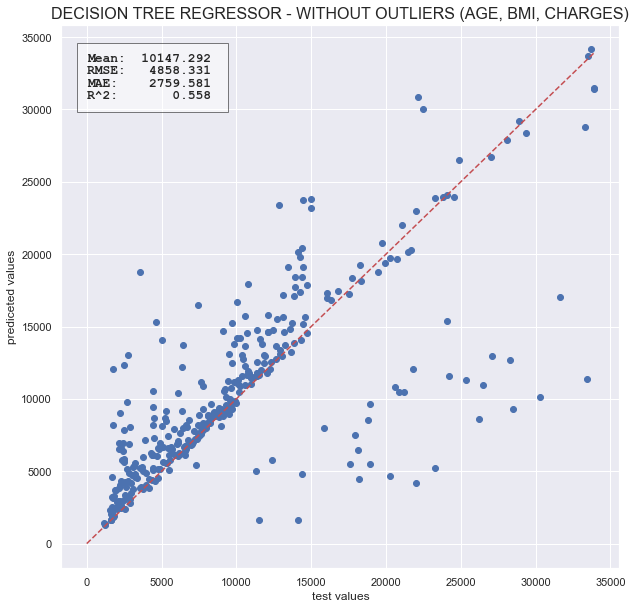

In [274]:
model_summary(yo_test,rf_yo_pred, "Decision Tree Regressor - without outliers (age, bmi, charges)")

In [268]:
col2 = ['age', 'bmi']
file_out2 = outlier_iqr(file, col2)
xoc = file_out2.drop(["charges","category", "sex_female", "region_southwest"], axis=1)
yoc = file_out2["charges"]
xoc_train, xoc_test, yoc_train, yoc_test = train_test_split(xoc,yoc,test_size=.3, random_state=24)
rf_out_charges = RandomForestRegressor().fit(xo_train, yo_train)
rf_yoc_pred = rf_out_charges.predict(xoc_test)
rf_out_charges.score(xoc_test, yoc_test)

0.8366233197995347

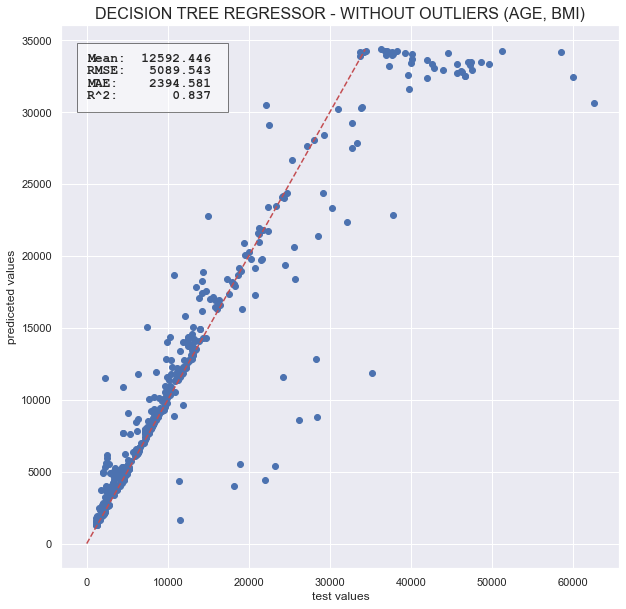

In [276]:
model_summary(yoc_test,rf_yoc_pred, "Decision Tree Regressor - without outliers (age, bmi)")